<a href="https://colab.research.google.com/github/paton838/works/blob/master/data-science/titanic/titanic_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Source: https://www.kaggle.com/c/titanic

In [1]:
import pandas as pd
import numpy as np
import re as re
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# read in the data
train = pd.read_csv("./train.csv")

In [0]:
# get the dataset for analysis
df = train

In [138]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [0]:
# There are a lot of missing data in the Cabin column. It suggests that using Cabin to do prediction may not be very reliable.

In [140]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [160]:
# Let's add a Companion column to df to indicate if the person has a companion
df['Companion'] = df['SibSp'] + df['Parch']
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Companion
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


In [159]:
df[['Companion', 'Survived']].groupby(['Companion']).agg(['mean', 'count'])

# Most of the people in the subset of data are recorded alone (537 people), and
  # the people who have a companion has a significantly higher chance to survive (55%) than the lone people (30%).
# This table also indicates that the people who have the highest survival chances (72%) have a family size of 3, which is a medium size family

# This result suggests that Companion would be a useful feature for predictions.

Survived      
               mean count
Companion                
0          0.303538   537
1          0.552795   161
2          0.578431   102
3          0.724138    29
4          0.200000    15
5          0.136364    22
6          0.333333    12
7          0.000000     6
10         0.000000     7

In [158]:
# Let's check out the Ticket Class vs Survival Rate
df[['Pclass', 'Survived']].groupby(['Pclass']).agg(['mean', 'count'])
# This result suggests that higher the Ticket Class, the survival rate is much higher.

# This result suggests that Pclass would be a useful feature for predictions.

Survived      
            mean count
Pclass                
1       0.629630   216
2       0.472826   184
3       0.242363   491

In [157]:
# Let's check out the Gender vs Survival Rate
df[['Sex', 'Survived']].groupby(['Sex']).agg(['mean', 'count'])
# This result suggests that being a female on Titanic has a much higher survival rate! (74% vs 19%)

# This result suggests that Sex would be a useful feature for predictions.

Survived      
            mean count
Sex                   
female  0.742038   314
male    0.188908   577

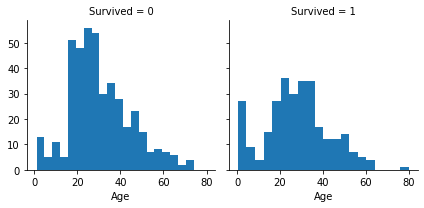

In [146]:
# Let's look at the Age distribution between survived and not survived
g = sns.FacetGrid(df, col='Survived')
g.map(plt.hist, 'Age', bins=20)

In [149]:
df.groupby(['Survived'])['Age'].mean()


Survived
0    30.626179
1    28.343690
Name: Age, dtype: float64

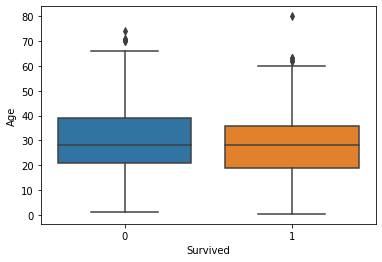

In [150]:
sns.boxplot(data=df, x='Survived', y='Age')
# This plot suggests that the median age is about the same.
  # However, the people who died tend to be older than the people who survived.

In [156]:
# Let's group the Fare in different categories
df3 = df[['Survived', 'Fare']]

df3.loc[ df['Fare'] <= 10, 'Fare']                           = 0
df3.loc[(df['Fare'] > 10) & (df3['Fare'] <= 20), 'Fare'] = 1
df3.loc[(df['Fare'] > 20) & (df3['Fare'] <= 30), 'Fare']   = 2
df3.loc[ df['Fare'] > 30, 'Fare']                              = 3

df3.groupby(['Fare'])['Survived'].agg(['mean', 'count'])

# This result shows that there is a positive relationship between Fare and Survival Rate.

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,mean,count
Fare,,
0.0,0.199405,336
1.0,0.424581,179
2.0,0.443662,142
3.0,0.581197,234


In [161]:
df[['Embarked', 'Survived']].groupby(['Embarked']).agg(['mean', 'count'])
# This result shows that most people got on-board from Southampton, and somehow the people who got on from Cherbourg have the highest survival rate. 

Survived      
              mean count
Embarked                
C         0.553571   168
Q         0.389610    77
S         0.336957   644

In [162]:
# =====================
# Let's look at the Name to see if the person has a special title or higher status resulted in higher survival rate
df4 = df[['Survived', 'Name']]

def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

df4['Title'] = df4['Name'].apply(get_title)
df4.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,Survived,Name,Title
0,0,"Braund, Mr. Owen Harris",Mr
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Mrs
2,1,"Heikkinen, Miss. Laina",Miss
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Mrs
4,0,"Allen, Mr. William Henry",Mr


In [163]:
df5 = df4[['Survived', 'Title']]

df5['Title'] = df5['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
df5['Title'] = df5['Title'].replace('Mlle', 'Miss')
df5['Title'] = df5['Title'].replace('Ms', 'Miss')
df5['Title'] = df5['Title'].replace('Mme', 'Mrs')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [171]:
df5.groupby(['Title'])['Survived'].agg(['mean', 'count'], result_type='expand').sort_values(by='mean', ascending=False)

# Again, the ladies have a much higher survival rate, followed by Master, and people with rare titles. 
  # The average men (Mr) are the majority of the group (517 people), and have the lowest survival rate.

,mean,count
Title,,
Mrs,0.793651,126
Miss,0.702703,185
Master,0.575000,40
Rare,0.347826,23
Mr,0.156673,517
